# STA 220 Assignment 3

Due __Februrary 23, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

In [21]:
import requests
from bs4 import BeautifulSoup
import re
import requests_cache
from concurrent.futures import ThreadPoolExecutor, as_completed 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
requests_cache.install_cache('imsdb_cache') 

__(a, i)__ Write a function that retrieves all links to movies in the database by scraping the _alphabetical_ section on [imsdb.com](https://imsdb.com/) and retrieve the links. _How many links did you find?_ 

In [8]:
def retrieve_movie_links():
    base_url = "https://imsdb.com"
    movie_links = []
    for i in range(-1, 26):
        if(i == -1):
            alphabetical_url = f"{base_url}/alphabetical/{i+1}"
        else:
            alphabetical_url = f"{base_url}/alphabetical/{chr(ord('a')+i)}"
        
        response = requests.get(alphabetical_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all links within the alphabetical listing
        for p in soup.find_all('p'):
            a_tag = p.find('a')
            if a_tag:
                href = a_tag.get('href')
                if href and 'Movie Scripts' in href:
                    movie_links.append(href)
    
    return movie_links

In [9]:
# Example usage
movie_links = retrieve_movie_links()
print(f"Total movie links found: {len(set(movie_links))}")

Total movie links found: 1213


__(ii)__ Write a function `fetch_script` that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie: 

```python
fetch_script('/Movie Scripts/10 Things I Hate About You Script.html')

>>> {'title': '10 Things I Hate About You',
     'writers': ['Karen McCullah Lutz', 'Kirsten Smith', 'William Shakespeare'],
     'genres': ['Comedy', 'Romance'],
     'date': 1997,
     'script': '...'}
```

The `script` field contains a string of the scraped script. Retrieve the information for all movies. _How many scripts did you retrieve?_

In [11]:
def fetch_script(url):
    try:
        base_url = "https://imsdb.com"
        movie_url = base_url+url
        with requests_cache.CachedSession('imsdb_cache') as session:
            response = session.get(movie_url)
            soup = BeautifulSoup(response.content, 'html.parser')

        # Extract title
        title_tag = soup.find('title')
        title = title_tag.text.replace(' Script at IMSDb.', '') if title_tag else 'Unknown'
        # print(title)

        # Extract writers
        writers_tag = soup.find('b', string='Writers')
        writers = []
        current_tag = writers_tag.find_next_sibling('a')
        while current_tag is not None:
            if current_tag.name == 'a' and 'writer' in current_tag['href']:
                writers.append(current_tag.text)
            current_tag = current_tag.find_next_sibling()

        # Extract genres
        genres_tag = soup.find('b', string='Genres')
        genres = []
        current_tag = genres_tag.find_next_sibling('a')
        while current_tag is not None:
            if current_tag.name == 'a' and 'genre' in current_tag['href']:
                genres.append(current_tag.text)
            current_tag = current_tag.find_next_sibling()
        
        # Extract script date
        date_tag = soup.find('b', string=lambda text: text and 'Date' in text)
        date = date_tag.next_sibling.strip(': ').strip() if date_tag else 'Unknown'
        
        
        # Assuming there's a link to the script we can extract
        script_url_tag = soup.find('a', href=True, string=re.compile(r'Read ".+" Script'))
        script_url = script_url_tag['href'] if script_url_tag else 'URL Not Found'

        # The actual script content needs to be fetched separately since it's not included in the provided source
        script_content = 'Script content not found.'
        if(script_url != 'URL Not Found'):
            with requests_cache.CachedSession('imsdb_cache') as session:
                script_response = session.get(base_url+script_url)
                script_soup = BeautifulSoup(script_response.content, 'html.parser')
            
            script_content_tag = script_soup.find('pre')
            script_content = script_content_tag.get_text(strip=True) if script_content_tag else 'Script content not found.'
        
        movie_details = {
            "title": title,
            "writers": writers,
            "genres": genres,
            "date": date,
            "script_url": script_url,
            "script_content": script_content
        }

        return movie_details
    
    except Exception as e:
        print(f"Error in fetching {url}: "+str(e))


In [12]:
count = 0
movie_info = {}
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_url = {executor.submit(fetch_script, url): url for url in movie_links}
    for future in as_completed(future_to_url):
        url = future_to_url[future]
        try:
            movie_details = future.result()
            if(movie_details and url not in movie_info and movie_details['script_url'] != 'URL Not Found'):
                count += 1
            movie_info[url] = movie_details
        except Exception as e:
            print(f"Error processing URL {url}: {e}")
            
print(f"Total number of scripts retrieved: {count}")

Total number of scripts retrieved: 1184


__(b)__ We are interested in the genres `'Musical'`, `'Horror'`, and `'Romance'`. Craft a barplot displaying the absolute counts for each of these categories. In each bar, color-code the fractions of movies that are also counted in another genres. 

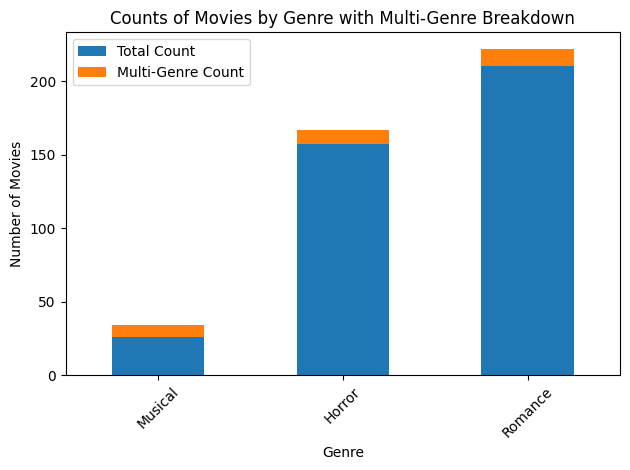

In [14]:
genres_of_interest = ["Musical", "Horror", "Romance"]

genre_counts = {genre: 0 for genre in genres_of_interest}
multi_genre_counts = {genre: 0 for genre in genres_of_interest}

for movie_details in movie_info.values():
    genres = movie_details["genres"]
    common_genres = set(genres) & set(genres_of_interest)
    for genre in common_genres:
        genre_counts[genre] += 1
        if len(common_genres) > 1:  
            multi_genre_counts[genre] += 1

df = pd.DataFrame({
    "Genre": genres_of_interest,
    "Total Count": [genre_counts[genre] for genre in genres_of_interest],
    "Multi-Genre Count": [multi_genre_counts[genre] for genre in genres_of_interest]
})

# Plot
fig, ax = plt.subplots()
df.plot(kind="bar", x="Genre", y=["Total Count", "Multi-Genre Count"], stacked=True, ax=ax)
ax.set_ylabel("Number of Movies")
ax.set_title("Counts of Movies by Genre with Multi-Genre Breakdown")
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()


__(c, i)__ Using only regex, write a function `tokenizer` that returns bigrams of all non-whitespace and non-punctuation characters, according to the test case below: 

```python
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)
>>> ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']
 ```

In [35]:
def tokenizer(text):
    words = re.findall(r'\b\w+\b', text.lower())  

    bigrams = [' '.join(pair) for pair in zip(words, words[1:])]

    return bigrams

In [17]:
# Test case
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokens = tokenizer(test)

for token in tokens:
    print(token)


neque porro
porro quisquam
quisquam est
est qui
qui dolorem
dolorem ipsum
ipsum quia
quia dolor
dolor sit
sit amet
amet consectetur
consectetur adipisci
adipisci velit
velit sed
sed quia
quia non
non numquam
numquam eius
eius modi
modi tempora
tempora incidunt
incidunt ut
ut labore
labore et
et dolore
dolore magnam
magnam aliquam
aliquam quaerat
quaerat voluptatem


In [28]:
# corpus = [movie_info['/Movie Scripts/10 Things I Hate About You Script.html']['script_content']]
# vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')
# tfidf_matrix = vectorizer.fit_transform(corpus)

In [33]:
# tokens = vectorizer.get_feature_names_out()

# # Print or inspect the tokens
# print(tokens[0])

0 fair


__(ii)__ Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (`sklearn.decomposition.TruncatedSVD`). _What fraction of variation is explained by the first principal component?_ 

In [36]:
# Step 2: Prepare Corpus
corpus = [details['script_content'] if details['script_content'] != "Script content not found." else "" for details in movie_info.values()]
titles = [details['title'] for details in movie_info.values()]
genres = [details['genres'] for details in movie_info.values()]

# Vectorize with TF-IDF
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(corpus)

# Step 3: PCA using TruncatedSVD
svd = TruncatedSVD(n_components=1)
principal_components = svd.fit_transform(tfidf_matrix)
explained_variance = svd.explained_variance_ratio_[0]

print(f"Fraction of variance explained by the first principal component: {explained_variance}")

Fraction of variance explained by the first principal component: 0.008952138958774907


__(iii)__ Generate a strip-plot for the first principal components versus all three genres. Does visualization indicate that a good classification could result from this approach? 

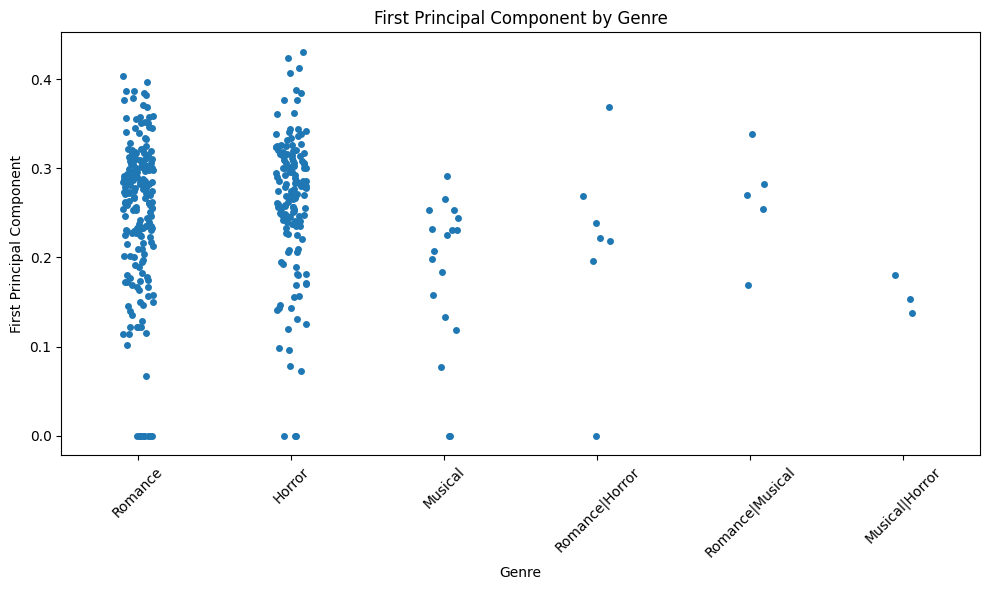

In [38]:
# Step 4: Visualization
df = pd.DataFrame({
    'First Principal Component': principal_components.ravel(),
    'Genre': ['|'.join(set(g) & set(genres_of_interest)) if set(g) & set(genres_of_interest) else 'Other' for g in genres],
    'Title': titles
})

# Filter DataFrame for genres of interest
df_filtered = df[df['Genre'] != 'Other']

# Plotting
plt.figure(figsize=(10, 6))
sns.stripplot(data=df_filtered, x='Genre', y='First Principal Component', jitter=True)
plt.title('First Principal Component by Genre')
plt.xlabel('Genre')
plt.ylabel('First Principal Component')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

While the plot does show some level of separation, the significant overlap suggests that classification based solely on the first principal component might not be very effective. For a good classification, one typically hopes to see more distinct and non-overlapping distributions for each category. The plot implies that additional components or other features might be necessary to improve classification performance.